In [1]:
from models.BYOL2_model import BYOL2
from data.custom_transforms import PadToSquare
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import sys
import torch
from torchvision.datasets import ImageFolder
import torchvision.models as models
import torchvision.transforms as T

In [2]:
def get_embeddings_labels(model, dataloader, mode):
    model.eval()
    embeddings = []
    labels = []
    for i, (batch, label) in enumerate(dataloader):
        batch = batch.to('cuda', dtype=torch.float)
        with torch.no_grad():
            current_projection, current_embedding = model(batch, return_embedding=mode)
        embeddings.append(current_embedding.to('cpu'))
        labels.append(label)
        sys.stdout.write('\rBatch {} done.'.format(i))
    return torch.cat(embeddings, dim=0), torch.cat(labels, dim=0).numpy()

def frame_image(img, frame_width, value=(0,0,0)):
    b = frame_width
    ny, nx = img.shape[0], img.shape[1]
    framed_img = np.stack([
        np.ones((b+ny+b, b+nx+b))*value[0],
        np.ones((b+ny+b, b+nx+b))*value[1],
        np.ones((b+ny+b, b+nx+b))*value[2]
    ])
    framed_img = framed_img.transpose(1,2,0).astype(np.uint8)
    framed_img[b:-b, b:-b] = img
    return framed_img

def right_border_image(img, border_width, value=(0,0,0)):
    b = border_width
    ny, nx = img.shape[0], img.shape[1]
    framed_img = np.stack([
        np.ones((ny, nx+b))*value[0],
        np.ones((ny, nx+b))*value[1],
        np.ones((ny, nx+b))*value[2]
    ])
    framed_img = framed_img.transpose(1,2,0).astype(np.uint8)
    framed_img[:,:-b] = img
    return framed_img

def plot_best_10_multiple(queries, queries_embeddings, queries_labels, catalogue, catalogue_embeddings, catalogue_labels, selected_indices, discard_first=True, lines_width=8):
    queries_embeddings = queries_embeddings.numpy()
    catalogue_embeddings = catalogue_embeddings.numpy()
    fig, axes = plt.subplots(nrows=len(selected_indices), ncols=11, figsize=(int(11*1.5), int(len(selected_indices)*1.5)))
    for i, selected_idx in enumerate(selected_indices):
        distances = np.sqrt(np.sum(np.square(catalogue_embeddings - queries_embeddings[selected_idx]), 1))
        indices = np.argsort(distances)
        if discard_first:
            best_indices = indices[1:11]
        else:
            best_indices = indices[0:10]
        best = []
        best_labels = []
        for idx in best_indices:
            best.append(catalogue[idx])
            best_labels.append(catalogue_labels[idx])
        selected = queries[selected_idx][0].numpy().transpose(1,2,0)
        selected_label = queries_labels[selected_idx]
        selected = right_border_image(selected,lines_width)
        axes[i][0].imshow(selected.reshape(224,224+lines_width, 3).astype(np.uint8))
        axes[i][0].axis('off')
        axes[i][1].axis('off')
        for j, (image, label) in enumerate(best):
            image = image.numpy().transpose(1,2,0)
            #if selected_label != best_labels[j]:
            #    image =  frame_image(image.reshape(224,224, 3), lines_width, (255,0,0))
            #    axes[i][j+2].imshow(image.reshape(224+lines_width*2,224+lines_width*2,3))
            #else:
            axes[i][j+1].imshow(image.reshape(224,224,3).astype(np.uint8))
            axes[i][j+1].axis('off')
    return fig, axes

In [3]:
transform_queries = T.Compose([
    PadToSquare(fill=255),
    T.Resize((224,224)),
    T.PILToTensor()
])

transform_catalogue = T.Compose([
    PadToSquare(fill=255),
    T.Resize((224,224)),
    T.PILToTensor()
])

queries = ImageFolder(
    root='/users/jmorales/Shoes/sketches_test/',
    transform=transform_queries)

catalogue = ImageFolder(
    root='/users/jmorales/Shoes/images_test/',
    transform=transform_catalogue)

queries_loader = torch.utils.data.DataLoader(queries, batch_size=100, shuffle=False)
catalogue_loader = torch.utils.data.DataLoader(catalogue, batch_size=100, shuffle=False)

encoder = models.resnet50(pretrained=False)
learner = BYOL2(
    encoder,
    image_size=224,
    hidden_layer='avgpool'
)
learner.load_state_dict(torch.load('../checkpoints/self_bimodal_byol_sketchy_then_shoes_5epochs.pt'))
learner = learner.to('cuda')

In [4]:
queries_embeddings, queries_labels = get_embeddings_labels(learner, queries_loader, 'target')

Batch 6 done.

In [5]:
catalogue_embeddings, catalogue_labels = get_embeddings_labels(learner, catalogue_loader, 'online')

Batch 1 done.

(<Figure size 1152x504 with 55 Axes>,
 array([[<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,


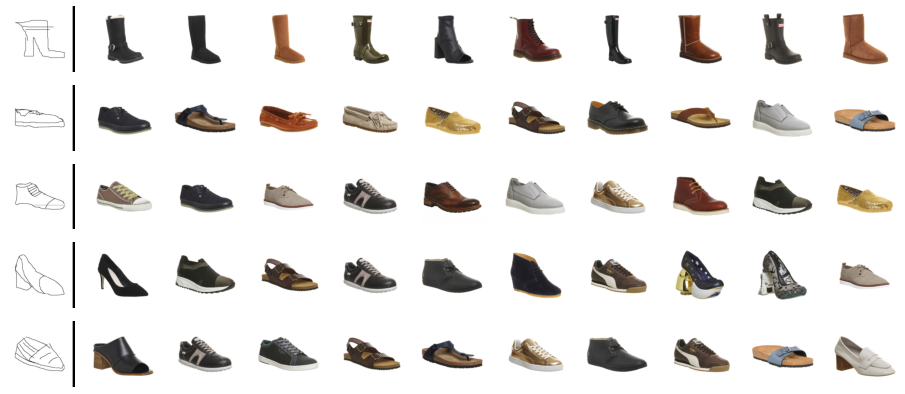

In [8]:
plot_best_10_multiple(queries, queries_embeddings, queries_labels, catalogue, catalogue_embeddings, catalogue_labels, [0,100,200,300,400])